In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull

In [35]:
# Cargar los datos
data = pd.read_csv('datasetUNC.csv', delimiter=';')
columns_to_drop = ['SUB PERIODS']
data = data.drop(columns=columns_to_drop)
data = data.dropna(axis=0)
data.drop(data[data['PROVINCE'] == 'Otro'].index, inplace=True)
data.drop(data[data['PROVINCE'] == 'other'].index, inplace=True)

In [37]:
# Asignaciones numéricas para diferentes columnas (usar los valores ya mapeados)
assignment_mapping = {
    'MENTAL DISORDER HISTORY': {'no': 10, 'yes': 0},
    'EDUCATION': {
        'Completed postgraduate': 8,
        'Incomplete tertiary or university': 5,
        'Completed high school': 3,
        'Incomplete postgraduate': 7,
        'Completed tertiary or university': 6,
        'Incomplete high school': 2,
        'Incomplete elementary school': 0,
        'Completed elementary school': 1,
        'Otro': 4
    },
    'SUIC ATTEMPT HISTORY': {'ideation': 5, 'no': 10, 'yes': 0},
    'LIVING WITH SOMEBODY': {'no': 0, 'yes': 10},
    'ECONOMIC INCOME': {'yes': 10, 'no': 0}
}

# Aplicar asignaciones numéricas
for column, mapping in assignment_mapping.items():
    data[column] = data[column].map(mapping)

/tmp/ipykernel_1075/2405767250.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  province_data = data.groupby('PROVINCE').mean()


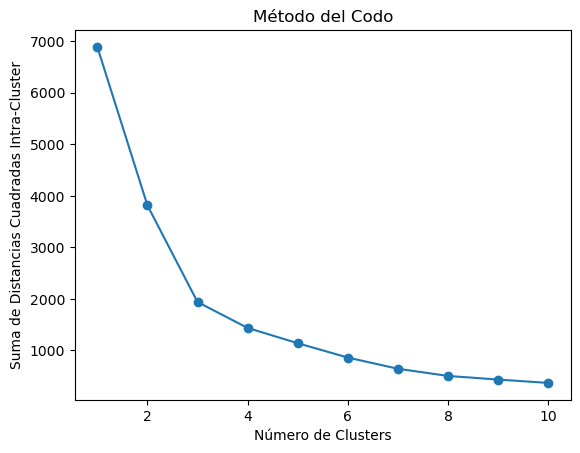

In [39]:
'''
n_clusters: En el paso de aplicar K-Means calcularemos
la cantidad de clusters con el Método del codo
'''
# Calcula la suma de las distancias cuadradas intra-cluster para diferentes valores de k
province_data = data.groupby('PROVINCE').mean()

inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    kmeans.fit(province_data)
    inertia_values.append(kmeans.inertia_)

# Grafica la suma de las distancias cuadradas intra-cluster en función de k
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Distancias Cuadradas Intra-Cluster')
plt.title('Método del Codo')
plt.show()

In [40]:
def lighten_color(color, cantidad=0.5):
    color_aclarado = tuple((1 - cantidad) * c + cantidad for c in color)
    return color_aclarado

QhullError: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1129873670  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0


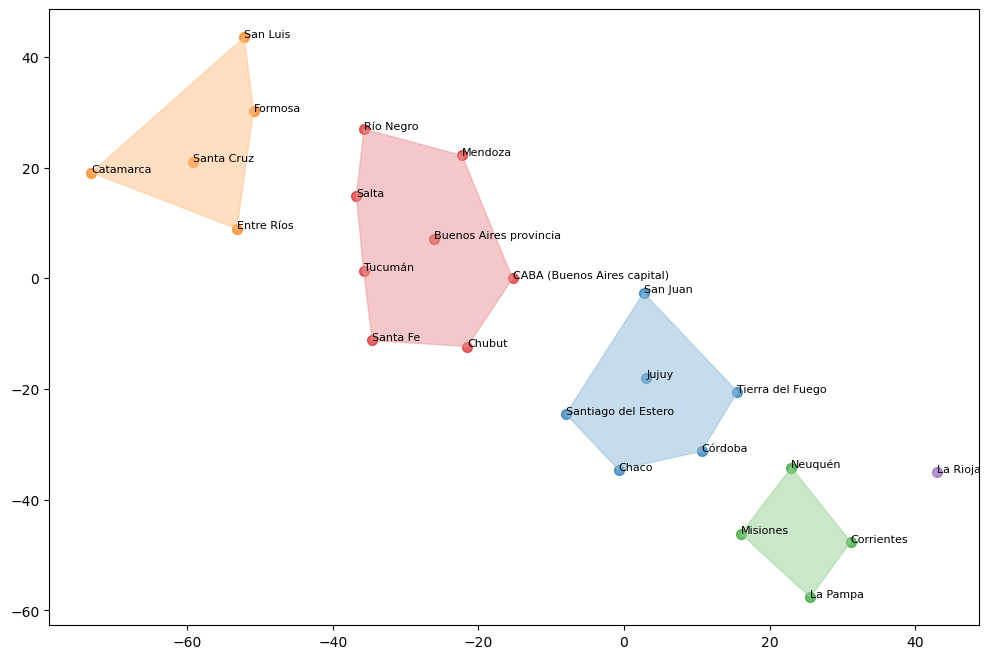

In [41]:
# Configuración de semilla aleatoria para reproducibilidad
random_seed = 0
np.random.seed(random_seed)

'''
n_clusters: decidimos usar 5 clusters, ya que probamos
con 3 y 4 y no obtuvimos resultados, ya que no se 
comporta como lo planeamos segun analisis de datos
previos.
'''

# Aplicar K-Means para clasificar las provincias en grupos
kmeans = KMeans(n_clusters=5, n_init=10, random_state=0).fit(province_data)

# Asignar un color a cada provincia en base a los clusters
province_data['Cluster'] = kmeans.labels_

'''
perplexity: En el paso de reducción de dimensionalidad con t-SNE, perplexity controla 
cómo se balancean las relaciones locales y globales en el 
espacio reducido. Valores bajos dan más importancia a las relaciones locales, mientras que 
valores altos dan más importancia a las relaciones globales. 
Puedes ajustar esto para obtener visualizaciones diferentes.
'''

# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=random_seed, perplexity=10)
tsne_coordinates = tsne.fit_transform(province_data)
province_data['tsne_x'] = tsne_coordinates[:, 0]
province_data['tsne_y'] = tsne_coordinates[:, 1]

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors  # Puedes cambiar 'tab10' a otro mapa de colores según tu preferencia
light_colors = [lighten_color(color, 0.5) for color in cluster_colors]

# Colores de áreas más claros relacionados con los clusters
#cluster_colors = ['red', 'green', 'orange', 'blue', 'purple']
#light_colors = ['lightblue', 'lightyellow', 'lightgreen', 'pink', 'lavender']

# Gráfico de dispersión con conjuntos de clusters y etiquetas de provincias
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = province_data[province_data['Cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)

    # Agregar etiquetas de provincias al gráfico
    for index, row in cluster_data.iterrows():
        plt.text(row['tsne_x'], row['tsne_y'], index, fontsize=8)

# Crear conjuntos de clusters con colores más claros relacionados
for cluster in unique_clusters:
    cluster_data = province_data[province_data['Cluster'] == cluster]
    hull = ConvexHull(cluster_data[['tsne_x', 'tsne_y']])
    plt.fill(cluster_data['tsne_x'].iloc[hull.vertices], cluster_data['tsne_y'].iloc[hull.vertices], color=light_colors[cluster], alpha=0.5, label='')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]
legend_elements.append(Patch(facecolor='gray', edgecolor='gray', alpha=0.2, label='Conjuntos de Clusters'))

plt.legend(handles=legend_elements, loc='upper left')
plt.title('Clustering de Provincias (K-Means con t-SNE)')
plt.xlabel('t-SNE Dimensión 1')
plt.ylabel('t-SNE Dimensión 2')
plt.show()